In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import krippendorff
from gensim.utils import simple_preprocess
from irrCAC.raw import CAC

import nltk
import pyLDAvis.gensim
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("error")

pyLDAvis.enable_notebook()

nltk.download('punkt')
# !python3 -m spacy download en

[nltk_data] Downloading package punkt to /Users/marcus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

color_pallete = sns.color_palette([grey, darkgreen, teal, blue, yellow])

# Feedback Analysis

In [109]:
feedback_df = pd.read_csv('../Menagerie/data/grades.csv', index_col=0)
feedback_df = feedback_df[~feedback_df['grade'].isnull()]
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and are organized in a way that makes the logical flow of operations somewhat easy to follow.,Readability,15,1,B+
1,620.0,Code is well organized into logical classes and methods. Indentation and whitespace is used consistently. Variable and method names are clear and meaningful. Methods are focused on single responsibilities. Access modifiers are appropriately used to encapsulate data.,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently indented, and uses meaningful names, whitespace and consistent spacing. Methods are focused and classes encapsulate data and behavior appropriately. This makes the overall program quite easy to read and understand.",Readability,15,1,A-
3,591.0,The code is well organized and readable. Indentation and whitespace are used consistently. Variable and method names are clear and meaningful.,Readability,15,1,A-
4,587.0,The code is well organized and readable. Indentation and whitespace are used consistently. Variable and method names are clear and meaningful.,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


## Multiple Graders

In [110]:
def map_participant_group(participant_id):
    if participant_id <= 4:
        return "1-4"
    elif 4 < participant_id <= 8:
        return "5-8"
    elif 8 < participant_id <= 12:
        return "9-12"
    elif 12 < participant_id <= 16:
        return "13-16"
    elif 16 < participant_id <= 20:
        return "17-20"
    elif 20 < participant_id <= 24:
        return "21-24"
    elif 24 < participant_id <= 28:
        return "25-28"

feedback_df['group'] = feedback_df['participant_id'].apply(map_participant_group)
feedback_df['group'] = pd.Categorical(feedback_df['group'], categories=['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
feedback_df = feedback_df.sort_values('group', ascending=True)
feedback_df.to_csv('../data/inter_rater.csv')
feedback_df.head()

,assignment_number,comments,skill,participant_id,batch,grade,group
0,302.0,"The code demonstrates a high level of organisation, consistent indentation, and meaningful identifier names.",Readability,3,2,A++,1-4
4,188.0,Some method names are misleading,Readability,2,2,B,1-4
3,542.0,NaN,Readability,2,2,A-,1-4
2,277.0,NaN,Readability,2,2,A-,1-4
1,303.0,NaN,Readability,2,2,A-,1-4


### Length

In [112]:
feedback_df = feedback_df[feedback_df['comments'] != 'No comment supplied']
feedback_df['comments'] = feedback_df['comments'].fillna('')

feedback_df['length'] = feedback_df['comments'].apply(lambda comment: len(simple_preprocess(comment)))

feedback_df_mean = feedback_df[['group', 'skill', 'assignment_number', 'length']].groupby(['skill', 'group', 'assignment_number'], observed=True).mean().reset_index()
feedback_df_mean['group'] = pd.Categorical(feedback_df_mean['group'], categories=['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
feedback_df_mean = feedback_df_mean.sort_values('group', ascending=True)
feedback_df_mean

,skill,group,assignment_number,length
0,Code Elegance,1-4,29.0,4.75
844,Readability,1-4,188.0,8.75
843,Readability,1-4,144.0,9.75
842,Readability,1-4,143.0,9.25
841,Readability,1-4,119.0,8.50
...,...,...,...,...
802,Documentation,25-28,74.0,8.50
803,Documentation,25-28,85.0,11.75
804,Documentation,25-28,121.0,10.75
537,Correctness,25-28,305.0,17.25


In [113]:
feedback_df_mean[['skill', 'length']].groupby('skill').mean()

,length
skill,
Code Elegance,11.716846
Correctness,14.696237
Documentation,9.599612
Readability,7.707437


In [114]:
feedback_df_mean[['group', 'skill', 'length']].groupby(['group', 'skill'], observed=True).mean().sort_values(['length'], ascending=False)

,,length
group,skill,
13-16,Correctness,32.052083
17-20,Correctness,21.200000
13-16,Code Elegance,20.281250
1-4,Correctness,19.043750
25-28,Code Elegance,17.956250
13-16,Readability,15.681250
17-20,Code Elegance,15.168750
13-16,Documentation,15.093750
25-28,Correctness,13.293750


In [115]:
feedback_df_mean[(feedback_df_mean['group'] == '13-16')][['skill', 'length']].groupby(['skill']).mean()

,length
skill,
Code Elegance,20.281250
Correctness,32.052083
Documentation,15.093750
Readability,15.681250


In [116]:
feedback_df_mean[['group', 'skill', 'length']].groupby(['group', 'skill'], observed=True)['length'].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))

group  skill        
1-4    Code Elegance     4.4375
       Correctness       3.0000
       Documentation     2.8125
       Readability       2.5625
5-8    Code Elegance     1.7500
       Correctness       5.6875
       Documentation     1.0625
       Readability       3.3125
9-12   Code Elegance     1.6250
       Correctness       2.0625
       Documentation     5.8750
       Readability       0.3125
13-16  Code Elegance     4.8750
       Correctness       9.9375
       Documentation     3.5000
       Readability       3.3125
17-20  Code Elegance     9.3125
       Correctness       7.6250
       Documentation     6.1875
       Readability       4.3750
21-24  Code Elegance     4.0000
       Correctness       2.8750
       Documentation     2.6250
       Readability       1.2500
25-28  Code Elegance    11.5625
       Correctness       5.6250
       Documentation     3.2500
       Readability       2.8125
Name: length, dtype: float64

In [117]:
feedback_df_mean[(feedback_df_mean['group'] == '1-4')][['skill', 'length']].groupby(['skill'])['length'].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))

skill
Code Elegance    4.4375
Correctness      3.0000
Documentation    2.8125
Readability      2.5625
Name: length, dtype: float64

In [118]:
feedback_df[(feedback_df['group'] == '1-4') & (feedback_df['skill'] == 'Correctness') & (feedback_df['assignment_number'] == 223)].sort_values('length', ascending=False)

,assignment_number,comments,skill,participant_id,batch,grade,group,length
11,223.0,"Core Tasks: All listed core tasks have been completed, indicating a comprehensive approach to the simulation's basic requirements.\n\nChallenge Tasks: Three challenge tasks are completed (Plants, Weather, Disease), demonstrating exceptional technical aptitude and creativity in extending the simulation beyond the basic requirements.\n\nBlueJ: Run's in BlueJ without any issues.",Correctness,3,2,A++,1-4,48
11,223.0,"Base and challenge tasks well implemented, but the simulation could be more stable.",Correctness,4,2,B+,1-4,13
11,223.0,"All base and challenge tasks implemented, program lags at later steps",Correctness,2,2,A+,1-4,11
11,223.0,Program functions well. Challenge tasks were attempted.,Correctness,1,2,A,1-4,7


In [119]:
feedback_df[(feedback_df['group'] == '1-4') &(feedback_df['skill'] == 'Correctness')][['participant_id', 'length']].groupby('participant_id').mean()

,length
participant_id,
1,9.000
2,10.575
3,46.325
4,10.275


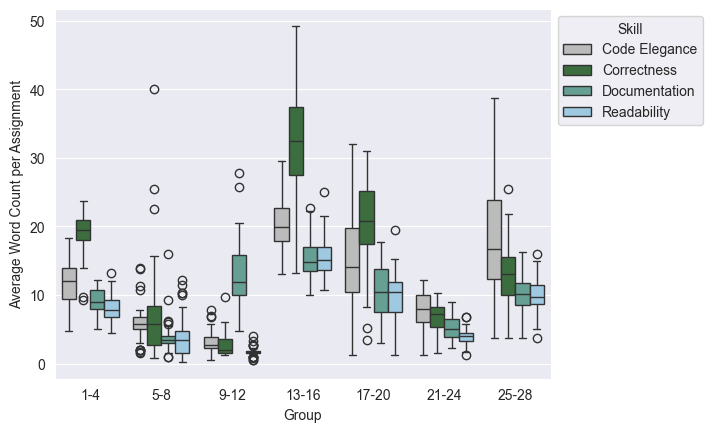

In [120]:
length_plt = sns.boxplot(feedback_df_mean, x='group', y='length', hue='skill', dodge=True, palette=sns.color_palette([grey, darkgreen, teal, blue]), hue_order=[ 'Code Elegance','Correctness', 'Documentation', 'Readability'])
length_plt.set(xlabel='Group', ylabel='Average Word Count per Assignment')
sns.move_legend(length_plt, "upper left", bbox_to_anchor=(1, 1), title='Skill')
length_plt.get_figure().savefig('plots/inter_rater_length.pdf', bbox_inches='tight')

### Comment Similarity

In [18]:
inter_rater_sim_df = pd.read_csv('../data/inter_rater_sim.csv')
inter_rater_sim_df = inter_rater_sim_df[(inter_rater_sim_df['feedback_1'] != 'No comment supplied' ) & (inter_rater_sim_df['feedback_2'] != 'No comment supplied')]

inter_rater_sim_df_mean = inter_rater_sim_df[['group', 'skill', 'assignment_number', 'sim']].groupby(['skill', 'group', 'assignment_number']).mean().reset_index()
inter_rater_sim_df_mean['group'] = pd.Categorical(inter_rater_sim_df_mean['group'], categories=['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
inter_rater_sim_df_mean = inter_rater_sim_df_mean.sort_values('group', ascending=True)
inter_rater_sim_df_mean.head()

,skill,group,assignment_number,sim
0,Code Elegance,1-4,29.0,0.332499
254,Correctness,1-4,575.0,0.529909
255,Correctness,1-4,588.0,0.369967
256,Correctness,1-4,601.0,0.515460
257,Correctness,1-4,612.0,0.450692


In [19]:
inter_rater_sim_df_mean[['group', 'skill', 'sim']].groupby(['group', 'skill'], observed=True).mean().sort_values(['sim'], ascending=False)

,,sim
group,skill,
25-28,Correctness,0.439806
1-4,Documentation,0.430350
13-16,Readability,0.425498
1-4,Correctness,0.420052
25-28,Readability,0.418868
13-16,Documentation,0.403042
25-28,Code Elegance,0.392716
13-16,Code Elegance,0.392158
17-20,Readability,0.378710


In [20]:
inter_rater_sim_df[(inter_rater_sim_df['group'] == '1-4')][['skill', 'sim']].groupby(['skill']).mean()

,sim
skill,
Code Elegance,0.363277
Correctness,0.421957
Documentation,0.430153
Readability,0.370913


In [21]:
inter_rater_sim_df[(inter_rater_sim_df['group'] == '5-8') & (inter_rater_sim_df['skill'] == 'Correctness') & (inter_rater_sim_df['assignment_number'] == 31)].sort_values('sim', ascending=False)

,group,skill,assignment_number,participant_id_1,participant_id_2,feedback_1,feedback_2,sim
1636,5-8,Correctness,31.0,6,8,At least 2 predators do not compete for same food source.,some challenge tasks are not completed such as disease.,0.188940
1637,5-8,Correctness,31.0,7,8,It is basically correct.,some challenge tasks are not completed such as disease.,0.068101
1635,5-8,Correctness,31.0,6,7,At least 2 predators do not compete for same food source.,It is basically correct.,0.035060


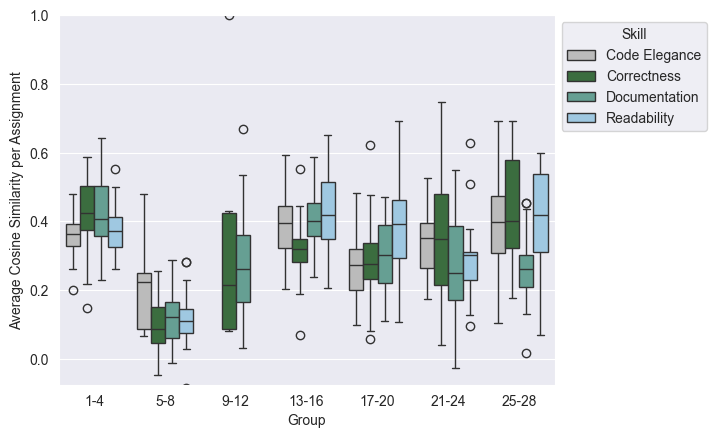

In [86]:
g = sns.boxplot(inter_rater_sim_df_mean, x='group', y='sim', hue='skill', palette=sns.color_palette([grey, darkgreen, teal, blue]), hue_order=[ 'Code Elegance', 'Correctness', 'Documentation', 'Readability'])
g.set(xlabel='Group', ylabel='Average Cosine Similarity per Assignment', ylim=(-0.075, 1))
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title='Skill')
g.get_figure().savefig('plots/inter_rater_sim.pdf', bbox_inches='tight')

## Dominant Topic
- Use nominal Krippendorf's and Gwet's AC1

In [23]:
correctness_dominant_df = pd.read_csv('../data/dominant_topics_correctness.csv')
correctness_dominant_df['skill'] = 'Correctness'

ce_dominant_df = pd.read_csv('../data/dominant_topics_code_elegance.csv')
ce_dominant_df['skill'] = 'Code Elegance'

read_dominant_df = pd.read_csv('../data/dominant_topics_readability.csv')
read_dominant_df['skill'] = 'Readability'

doc_dominant_df = pd.read_csv('../data/dominant_topics_documentation.csv')
doc_dominant_df['skill'] = 'Documentation'

dominant_df = pd.concat([correctness_dominant_df, ce_dominant_df, read_dominant_df, doc_dominant_df])

dominant_df = dominant_df[dominant_df['assignment_number'] != 105]

dominant_df['skill'].value_counts()

skill
Correctness      710
Documentation    707
Code Elegance    674
Readability      628
Name: count, dtype: int64

In [24]:
dominant_df['group'] = dominant_df['participant_id'].apply(map_participant_group)
dominant_df['group'] = pd.Categorical(dominant_df['group'], categories=['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
dominant_df = dominant_df.sort_values('group', ascending=True)
dominant_df['Dominant_Topic'] = pd.Categorical(dominant_df['Dominant_Topic'])

# dominant_df = dominant_df[dominant_df['group'] != '9-12']
dominant_df.head()

,assignment_number,comments,participant_id,batch,processed_text,Dominant_Topic,Perc_Contribution,Topic_Keywords,All_Topics,skill,group
652,601.0,"Code could make use of abstract classes to improve extensibility and breakdown longer functions into smaller, modular functions",2,1,"['code', 'use', 'abstract', 'class', 'extensibility', 'breakdown', 'small', 'modular']",Code Structure,0.525240,"structure, readable, extensibility, repetition, separate, different, hierarchy, encapsulate, encapsulation, abstract","[('Code Structure', 0.5252403), ('Inheritance', 0.33228123), ('Design', 0.14247845)]",Code Elegance,1-4
626,234.0,Good readability.,1,1,['good'],Naming and Whitespace,0.500000,"naming, improve, indentation, consistent, organise, long, identifier, understandable, demonstrate, inconsistent","[('Naming and Whitespace', 0.5), ('Structure', 0.5)]",Readability,1-4
625,601.0,Generally good readability.,1,1,['good'],Naming and Whitespace,0.500000,"naming, improve, indentation, consistent, organise, long, identifier, understandable, demonstrate, inconsistent","[('Naming and Whitespace', 0.5), ('Structure', 0.5)]",Readability,1-4
624,629.0,Some unconvential shorthands are used for some variables. It is,1,1,"['unconvential', 'shorthand', 'use']",Naming and Whitespace,0.500000,"naming, improve, indentation, consistent, organise, long, identifier, understandable, demonstrate, inconsistent","[('Naming and Whitespace', 0.5), ('Structure', 0.5)]",Readability,1-4
623,588.0,"Inconsistent casing where unnecessary. Generally good readability, otherwise.",1,1,"['inconsistent', 'casing', 'unnecessary', 'good']",Structure,0.746754,"structure, clear, readable, comment, understand, modifier, whitespace, inconsistent, space, convention","[('Structure', 0.7467537), ('Naming and Whitespace', 0.2532463)]",Readability,1-4


In [25]:
dominant_df['Dominant_Topic'].unique()

['Code Structure', 'Naming and Whitespace', 'Structure', 'Areas of Improvement', 'Compilation/Errors', 'Quality', 'Design', 'Inheritance', 'Areas of Achievement', 'Implementation/Creativity']
Categories (10, object): ['Areas of Achievement', 'Areas of Improvement', 'Code Structure', 'Compilation/Errors', ..., 'Inheritance', 'Naming and Whitespace', 'Quality', 'Structure']

### Distribution per group

In [26]:
dist_df = dominant_df.copy().sort_values(['skill', 'group', 'participant_id'])
dist_df.head()

,assignment_number,comments,participant_id,batch,processed_text,Dominant_Topic,Perc_Contribution,Topic_Keywords,All_Topics,skill,group
658,316.0,Animals and Plants extend Entity. Animals may be abstracted further into 'Predator' and 'Prey' classes for better extendability.,1,1,"['entity', 'abstract', 'class', 'extendability']",Inheritance,0.666597,"abstract, hierarchy, reusability, maintainable, maintainability, extensibility, encapsulation, separate, encapsulate, approach","[('Inheritance', 0.66659683), ('Design', 0.16670544), ('Code Structure', 0.1666977)]",Code Elegance,1-4
659,554.0,Program shows good opportunity for extendability. Handful of methods have low cohesion.,1,1,"['program', 'opportunity', 'extendability', 'handful', 'low', 'cohesion']",Inheritance,0.333333,"abstract, hierarchy, reusability, maintainable, maintainability, extensibility, encapsulation, separate, encapsulate, approach","[('Inheritance', 0.33333334), ('Design', 0.33333334), ('Code Structure', 0.33333334)]",Code Elegance,1-4
660,274.0,Class hierarchy works well. A lot of variables are not clear for what they are used for. Animal stats are an enum in Animal. Reason for this is unclear.,1,1,"['class', 'hierarchy', 'work', 'clear', 'use', 'stat', 'enum', 'reason', 'unclear']",Inheritance,0.665956,"abstract, hierarchy, reusability, maintainable, maintainability, extensibility, encapsulation, separate, encapsulate, approach","[('Inheritance', 0.66595596), ('Code Structure', 0.16735016), ('Design', 0.16669385)]",Code Elegance,1-4
661,36.0,Class hierarchy makes sense. Final variables that require adjustment should not be kept in a class. They should be kept in the relevant method.,1,1,"['class', 'hierarchy', 'sense', 'final', 'require', 'adjustment', 'keep', 'class', 'keep', 'relevant']",Inheritance,0.665955,"abstract, hierarchy, reusability, maintainable, maintainability, extensibility, encapsulation, separate, encapsulate, approach","[('Inheritance', 0.66595465), ('Code Structure', 0.16735144), ('Design', 0.16669388)]",Code Elegance,1-4
662,522.0,Code is generally implemented well. Some inconsistent design decisions. Some methods have low cohesion (e.g. incrementAge also determines if an animal dies),1,1,"['inconsistent', 'design', 'decision', 'low', 'cohesion', 'incrementage', 'determine', 'die']",Design,0.666623,"design, implementation, approach, modularity, encapsulation, encapsulate, segment, subclass, abstract, structure","[('Design', 0.6666234), ('Code Structure', 0.16669358), ('Inheritance', 0.16668303)]",Code Elegance,1-4


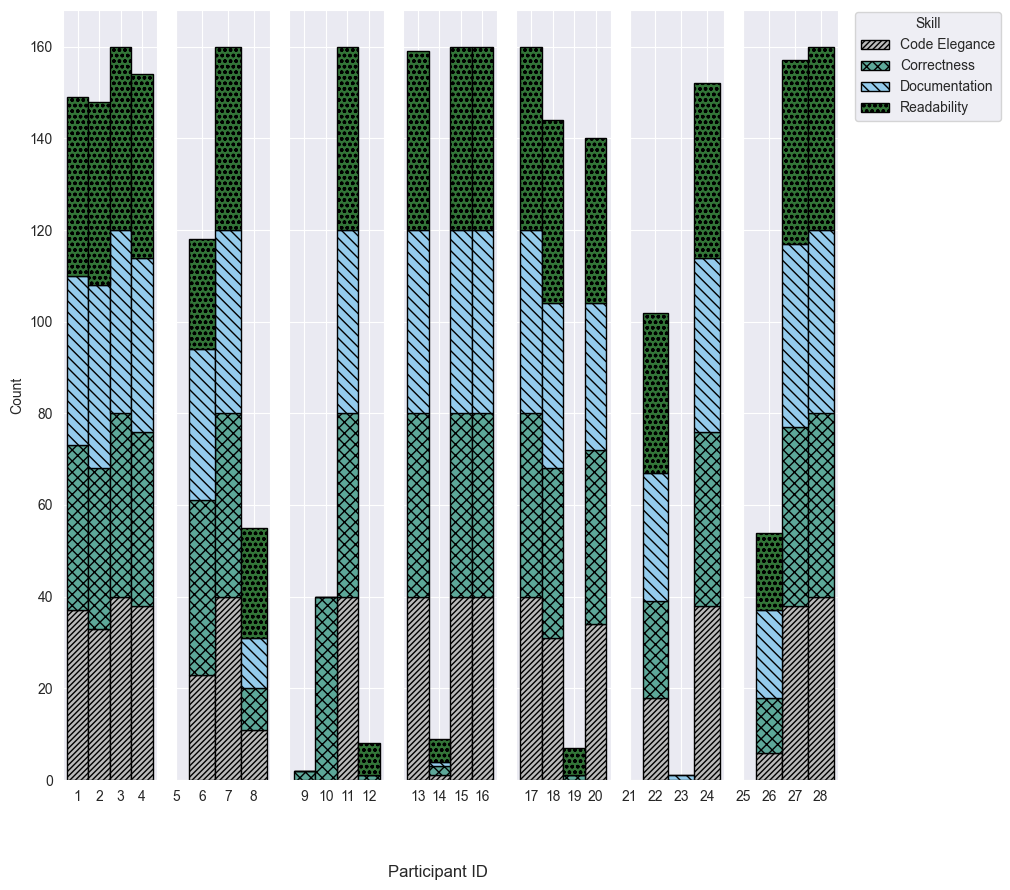

In [85]:
fig, axs = plt.subplots(1, 7, figsize=(10, 10), sharey=True)

groups = dist_df['group'].unique().tolist()

for i in range(len(groups)):
    g = sns.histplot(dist_df[dist_df['group'] == groups[i]], x='participant_id', hue='skill', multiple='stack', discrete=True, ax=axs[i], legend=False, stat='count', hue_order=['Correctness', 'Code Elegance', 'Documentation', 'Readability'])
    group_split = groups[i].split('-')
    axs[i].set_xticks(range(int(group_split[0]), int(group_split[1]) + 1))
    axs[i].set(xlabel='')

    hatches = ['//', 'x', '\\', 'o']
    colors = [grey, teal, blue, darkgreen]
    styles = zip(hatches, colors)

    for style, these_bars in zip(styles, g.containers):
        for this_bar in these_bars:
            this_bar.set_hatch(3 * style[0])
            this_bar.set_facecolor(style[1])
            this_bar.set_edgecolor('black')
    
    
fig.supxlabel('Participant ID')
fig.legend(labels=[ 'Code Elegance', 'Correctness','Documentation', 'Readability'], title='Skill', bbox_to_anchor=(1.07, 0.885))
fig.savefig('plots/feedback_dist_participant.pdf', bbox_inches='tight')

### Inter-rater metrics
All calculations are based on those that have provided feedback for the skill. For example, in group 21-24, only 22 and 24 gave feedback all on four topics, 21 provided no feedback and 23 provided 1 piece of feedback for code elegance.
So for the other skills, the metrics are calculated between the two raters 22 and 24, instead of four raters.

#### Group 9-12
Krippendorf's Alpha Results
- Correctness - Participants 11 and 12 provided feedback, with 11 providing feedback on all assignments, 12 only provided feedback on 7 and only gave feedback on the same topic.
    - As only unique pair existed $=> m_u = 1$ and $o_{ck} = \sum_{u}{\frac{\text{Number of } c-k \text{ pairs in unit } u}{m_u - 1}}$ therefore, $m_u - 1 = 0$ and results in a Zero Division Error
- Code Elegance - Only one rater (11) provided ratings
- Readability - Only one rater (11) provided ratings
- Documentation - Only skill that two raters (10 and 11) provided feedback on for all 40 assignments, 9 provided 2 pieces of feedback, and 12 provided 1.

AC1 Results
- Correctness - As participant 12 only gave feed back on one topic
    - $p_{k+} = 1, p_{+k} = 1 => \pi_k = 0 => p_e = 0$
    - $p_a = 1$
    - $\gamma = \frac{p_a - p_e}{1 - p_e} = 1$
- Code elegance and readability - only one rater
- Documentation - see above

In [133]:
# dominant_df = dominant_df[dominant_df['group'] != '9-12']
dominant_df['participant_id'].unique()

array([ 2,  1,  3,  4,  7,  8,  6, 11, 10, 12,  9, 13, 16, 15, 14, 18, 17,
       19, 20, 24, 22, 23, 28, 27, 26])

In [108]:
# Topics are norminal

def calculate_krippendorrf_alpha(skill, group):
    skill_df = dominant_df[dominant_df['skill'] == skill][['participant_id', 'assignment_number', 'group', 'Dominant_Topic']].copy()
    group_df = skill_df[skill_df['group'] == group].sort_values(by='participant_id')

    group_df['Dominant_Topic'] = group_df['Dominant_Topic'].cat.codes
    
    pivot = group_df.pivot(columns='assignment_number', index='participant_id', values='Dominant_Topic')

    return krippendorff.alpha(pivot.to_numpy(), level_of_measurement='nominal')

In [112]:
calculate_krippendorrf_alpha('Correctness', '9-12')

/Users/marcus/workspace/Programming/Consistency_In_Grading_Analysis/venv3.10/lib/python3.10/site-packages/krippendorff/krippendorff.py:364: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - (o * d).sum() / (e * d).sum()


nan

In [118]:
def calculate_ac1(skill, group):
    skill_df = dominant_df[dominant_df['skill'] == skill][['participant_id', 'assignment_number', 'group', 'Dominant_Topic']].copy()
    group_df = skill_df[skill_df['group'] == group].sort_values(by='participant_id')

    group_df['Dominant_Topic'] = group_df['Dominant_Topic'].cat.codes
    # Transpose pivot to get in form required by library rater by assignment
    pivot = group_df.pivot(columns='assignment_number', index='participant_id', values='Dominant_Topic').T
    
    cac = CAC(pivot)

    return cac.gwet()['est']['coefficient_value']

In [119]:
calculate_ac1('Correctness', '9-12')

1.0

In [120]:
def calculate_all_reliability_metric(metric):
    results_df = None

    for skill in ['Correctness', 'Readability', 'Code Elegance', 'Documentation']:
        for group in dominant_df['group'].unique():
            try:
                if metric == 'krippendorff':
                    metric_result = calculate_krippendorrf_alpha(skill, group)
                else:
                    metric_result = calculate_ac1(skill, group)
                
            except ValueError as e:
                print(f'Error entries check data for: {group} - {skill} \n Error: {e}')
                metric_result = np.nan
            except RuntimeWarning as e:
                print(f'Math error, probably ZeroDivision, see: {e}')
                metric_result = np.nan

            results_df = pd.concat([results_df, pd.DataFrame({
                'group': group,
                'skill': skill,
                'metric_result': metric_result}, index=[0])])

            results_df['group'] = pd.Categorical(results_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])

    return results_df

In [125]:
alpha_df = calculate_all_reliability_metric('krippendorff').sort_values(by='group')
alpha_df

Math error, probably ZeroDivision, see: invalid value encountered in scalar divide
Error entries check data for: 9-12 - Readability 
 Error: There has to be at least one unit with values assigned by at least two coders.
Error entries check data for: 9-12 - Code Elegance 
 Error: There has to be more than one value in the domain.


,group,skill,metric_result
0,1-4,Correctness,-0.176107
0,1-4,Documentation,-0.060932
0,1-4,Code Elegance,0.003680
0,1-4,Readability,0.017096
0,5-8,Correctness,-0.132075
0,5-8,Code Elegance,-0.333140
0,5-8,Documentation,-0.295933
0,5-8,Readability,-0.297872
0,9-12,Code Elegance,NaN
0,9-12,Documentation,-0.105392


In [130]:
alpha_df[['skill', 'metric_result']].groupby(['skill']).mean()

,metric_result
skill,
Code Elegance,-0.181853
Correctness,-0.112135
Documentation,-0.108340
Readability,-0.196082


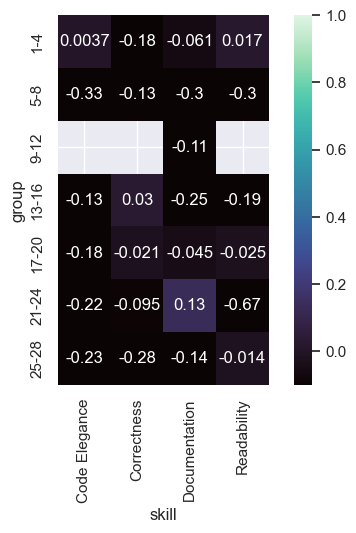

In [122]:
# Errors thrown here as 9-12 only has one rater in two topics

pivot_df = alpha_df.pivot(index='group', columns='skill', values='metric_result')#.transpose()
g = sns.heatmap(pivot_df, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
# g.get_figure().savefig('plots/krippendorrf.pdf', bbox_inches='tight')

In [123]:
# Errors thrown here as 9-12 only has one rater in two topics

ac1_df = calculate_all_reliability_metric('ac1').sort_values(by='group')
ac1_df.head()

Math error, probably ZeroDivision, see: invalid value encountered in scalar divide
Math error, probably ZeroDivision, see: invalid value encountered in scalar divide


,group,skill,metric_result
0,1-4,Correctness,0.03141
0,1-4,Documentation,0.09163
0,1-4,Code Elegance,0.39224
0,1-4,Readability,0.31664
0,5-8,Correctness,0.26097


In [132]:
ac1_df[['skill', 'metric_result']].groupby(['skill']).mean()

,metric_result
skill,
Code Elegance,0.071180
Correctness,0.437709
Documentation,0.146137
Readability,0.032435


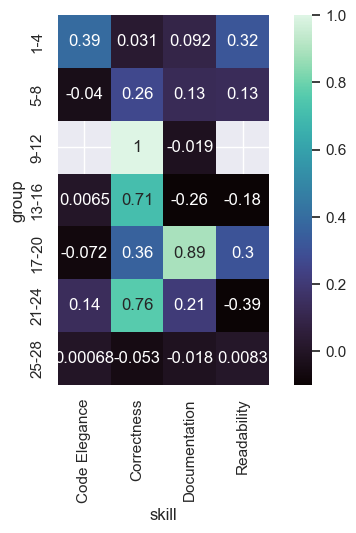

In [96]:
pivot_df = ac1_df.pivot(index='group', columns='skill', values='metric_result')#.transpose()
g = sns.heatmap(pivot_df, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
g.get_figure().savefig('plots/ac1.pdf', bbox_inches='tight')

In [97]:
dominant_df[(dominant_df['group'] == '9-12') & (dominant_df['skill'] == 'Correctness')][['Dominant_Topic', 'participant_id', 'comments']].groupby(['Dominant_Topic', 'participant_id']).count()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_13516/1072490072.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dominant_df[(dominant_df['group'] == '9-12') & (dominant_df['skill'] == 'Correctness')][['Dominant_Topic', 'participant_id', 'comments']].groupby(['Dominant_Topic', 'participant_id']).count()


comments
Dominant_Topic            participant_id          
Areas of Achievement      11                     0
                          12                     0
Areas of Improvement      11                     0
                          12                     0
Code Structure            11                     0
                          12                     0
Compilation/Errors        11                    35
                          12                     7
Design                    11                     0
                          12                     0
Implementation/Creativity 11                     3
                          12                     0
Inheritance               11                     0
                          12                     0
Naming and Whitespace     11                     0
                          12                     0
Quality                   11                     2
                          12                     0
Structure                 11                     0
                          12                     0

#### Krippendorf's vs Threshold

In [98]:
experience_df = pd.read_csv('../data/experience_formatted.csv')
experience_df['group'] = experience_df['participant_id'].apply(map_participant_group)
exp_alpha_df = pd.merge(experience_df, alpha_df, on='group', how='right')
exp_alpha_df

,Unnamed: 0,participant_id,prog_exp,grading_exp,group,skill,metric_result
0,2,4,5+ years,No grading \n experience,1-4,Correctness,-0.176107
1,6,3,5+ years,1 - 2 years,1-4,Correctness,-0.176107
2,9,2,5+ years,No grading \n experience,1-4,Correctness,-0.176107
3,14,1,5+ years,0 - 1 years,1-4,Correctness,-0.176107
4,2,4,5+ years,No grading \n experience,1-4,Documentation,-0.060932
...,...,...,...,...,...,...,...
107,26,28,5+ years,No grading \n experience,25-28,Code Elegance,-0.226753
108,10,25,5+ years,No grading \n experience,25-28,Documentation,-0.135566
109,17,26,3 - 5 years,0 - 1 years,25-28,Documentation,-0.135566
110,18,27,5+ years,No grading \n experience,25-28,Documentation,-0.135566


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_13516/4166618091.py:4: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  g_inter_exp_box_plt = sns.boxplot(exp_alpha_df, x='grading_exp', y='metric_result', hue='skill', order=['No grading \n experience', '0 - 1 years', '1 - 2 years', '2 - 3 years'], palette=color_pallete, ax=inter_exp_plt.ax_joint)


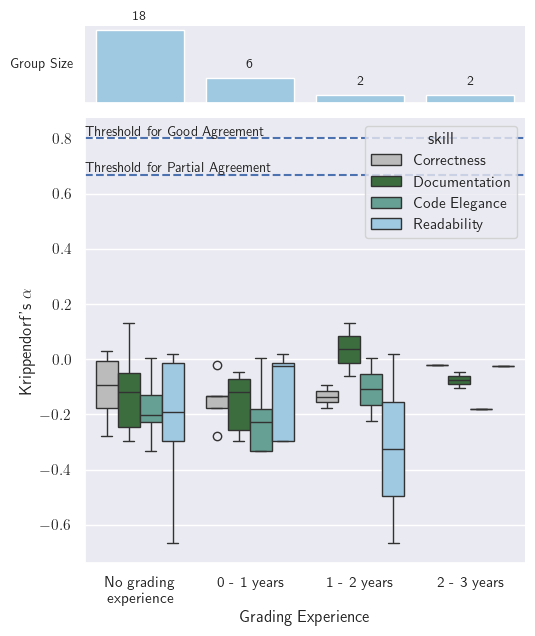

In [99]:
sns.set(rc={'text.usetex': True})

inter_exp_plt = sns.JointGrid()
g_inter_exp_box_plt = sns.boxplot(exp_alpha_df, x='grading_exp', y='metric_result', hue='skill', order=['No grading \n experience', '0 - 1 years', '1 - 2 years', '2 - 3 years'], palette=color_pallete, ax=inter_exp_plt.ax_joint)
sns.countplot(experience_df, x='grading_exp', ax=inter_exp_plt.ax_marg_x, color=blue)
inter_exp_plt.ax_marg_y.remove()

g_inter_exp_box_plt.set(xlabel='Grading Experience', ylabel="Krippendorf's $\\alpha$")

inter_exp_plt.ax_marg_x.set_title('Group Size', fontsize=10, loc='left', y=0.35, x=-0.17)

inter_exp_plt.ax_joint.axhline(0.667, ls='--')
inter_exp_plt.ax_joint.axhline(0.8, ls='--')
inter_exp_plt.ax_joint.text(-0.5, 0.68, 'Threshold for Partial Agreement', fontsize=10)
inter_exp_plt.ax_joint.text(-0.5, 0.81, 'Threshold for Good Agreement', fontsize=10)

for p in inter_exp_plt.ax_marg_x.patches:
    inter_exp_plt.ax_marg_x.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=10)

inter_exp_plt.savefig('plots/inter_exp_dist.pdf', bbox_inches='tight')
sns.set(rc={'text.usetex': False})